# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, last, when, sum, mean
from pyspark.sql.types import IntegerType

from datetime import datetime

import matplotlib.pyplot as plt


In [2]:
# create a Spark session
spark = SparkSession.builder \
        .master("local") \
        .appName("Sparkify") \
        .getOrCreate()
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# specify file path of the dataset
sparkify_data = "mini_sparkify_event_data.json"

In [4]:
# read json file
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
# number of records in the dataset
size_orig = df.count()
print("The dataset has {} entries.".format(size_orig))

The dataset has 286500 entries.


In [6]:
# print the dataset schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# helper function for more convenience
def printCleandSize(size_clean, size_orig=size_orig):
    print("Dataset size after cleaning process: {} - removed {} entries".format(size_clean, size_orig - size_clean))

In [8]:
# Drop NA-values in the user defined columns. 
'''
Values where NA-values must be prevented:
- userId -> identifying the user
- page -> which page was accessed: e.g. downgrade/upgrade/next song:
- registration: the date of the registration 
- ts -> play-time: needed for analyzing the user activity during the day 
- level -> free/paid: needed for analyzing the churn rate
- status -> HTTP status codes: check if user is unsatisfied with Sparkify's availability 
- method -> HTTP request type: check if user is unsatisfied with Sparkify's availability
- gender -> check if there is a different behaviour for different gender
- sessionId -> assures the session was valid

usefull but not necessary relevant:
- auth -> "Cancalled / Logged In"
- firstName -> first name of te user
- lastName -> last name of the user
- location -> user geographical location

- song -> name of the played song
- artist -> name of the artist 
- length -> length of the song (do not remove NA's here or the column page only contains "next page")

- userAgent -> difference between Win/Mac users
- itemInSession
'''
df_clean = df.dropna(how = "any", subset = ["userId", "sessionId", "method", "page", "ts", 
                                            "registration", "level", "userAgent", "method",
                                            "status"])
                           
size_clean = df_clean.count()
printCleandSize(size_clean)

Dataset size after cleaning process: 278154 - removed 8346 entries


In [12]:
# cleaning the gender column - assuming the null values can be either null or a other gender
# later this groups will be converted into numerical values
df_clean = df_clean.fillna("null/other", subset=["gender"])
df_clean.groupby("gender").count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



In [13]:
# check if after droping the NA-values there are still some invalid values
df_clean.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
+------+
only showing top 20 rows



In [14]:
# filter userIds with an empty string
df_clean = df_clean.filter(df_clean["userId"] != "")
printCleandSize(df_clean.count())

Dataset size after cleaning process: 278154 - removed 8346 entries


In [15]:
# user defined function to extract the play hour from the timestamp
get_hour = udf(lambda x: datetime.fromtimestamp(x / 1000.0).hour, IntegerType())
# create the a new column "hour" this holds the hour when a user interacted with the system
df_clean = df_clean.withColumn("hour", get_hour(df.ts))

In [16]:
# side effect - the invalid usernames matched with the null/other values in the gender
df_clean.groupby("gender").count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Preliminary Analysis
The following part covers a basic analysis of Sparkify's user data.

In [17]:
# get the number of records
total_records = df_clean.count()
print("The dataset contains {} records.".format(total_records))

The dataset contains 278154 records.


#### User Groups (paid and unpaid memberships)
In this section the difference between paid and unpaid memberhips are shown.

In [18]:
# get membership data
pd_user_level = df_clean.groupby("level").count().toPandas()
pd_user_level

,level,count
0,free,55721
1,paid,222433


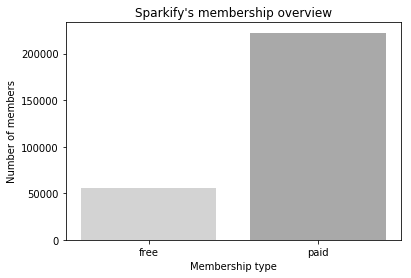

In [19]:
# plot memberhsip data
plt.figure();
plt.bar(pd_user_level.level.values, pd_user_level["count"], color=["lightgray", "darkgray"]);
plt.xlabel("Membership type");
plt.ylabel("Number of members");
plt.title("Sparkify's membership overview");

In [20]:
# calculate the percentages
free_percentage = pd_user_level["count"][0] / total_records
paid_percentage = 1 - free_percentage
print("Membership overview:"+
      "\n free: {:.2f}% ({})\n paid: {:.2f}% ({})".format(free_percentage, pd_user_level["count"][0], 
                                                          paid_percentage, pd_user_level["count"][1]))

Membership overview:
 free: 0.20% (55721)
 paid: 0.80% (222433)


#### User groups: gender
Are Sparkify's user equally distributed between all genders:

In [21]:
pd_gender = df_clean.groupby("gender").count().toPandas()
pd_gender.gender = pd_gender.gender.apply(lambda x: "female" if x == "F" else "male")

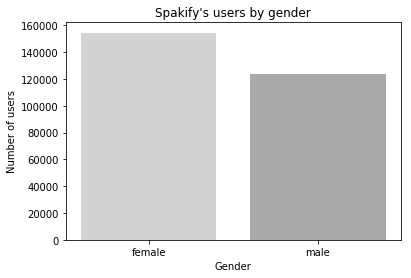

In [22]:
plt.figure();
plt.bar(pd_gender["gender"], pd_gender["count"], color=["lightgray", "darkgray"]);
plt.ylabel("Number of users");
plt.xlabel("Gender");
plt.title("Spakify's users by gender");

In [23]:
female_users = pd_gender["count"][0]/ total_records
female_users

0.55572812183179099

In [24]:
male_users = pd_gender["count"][1] / total_records
male_users

0.44427187816820896

In [25]:
female_users - male_users

0.11145624366358203

The amount of female users are a bit higher (+ 11%) than the amount of male users.

#### Playtime over the day 
Discover the playtime over the day in respect to different groups:
* all users
* gender
* payed / unpaid

In [26]:
pd_playtime_all = df_clean.groupby("hour").count().sort("hour").toPandas()

In [27]:
pd_playtime_paid = df_clean.where("level == 'paid'").groupby("hour").count().sort("hour").toPandas()

In [28]:
pd_playtime_unpaid = df_clean.where("level != 'paid'").groupby("hour").count().sort("hour").toPandas()

In [29]:
pd_playtime_men = df_clean.where("gender == 'M'").groupby("hour").count().sort("hour").toPandas()

In [30]:
pd_playtime_female = df_clean.where("gender == 'F'").groupby("hour").count().sort("hour").toPandas()

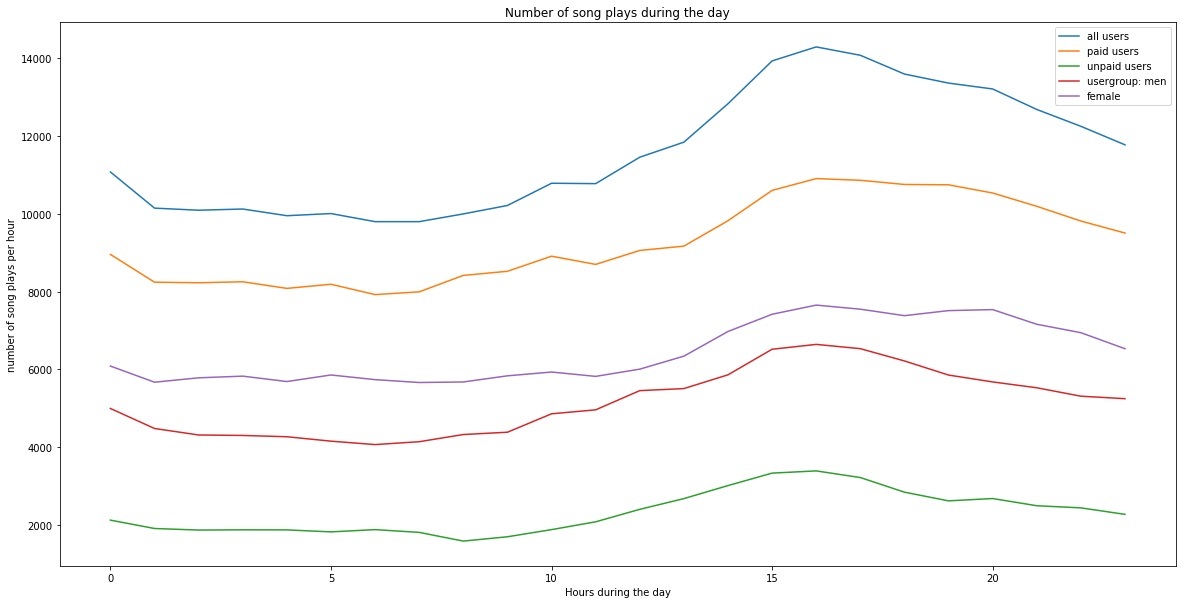

In [31]:
plt.figure(figsize=[20,10]);
plt.plot(pd_playtime_all["count"], label="all users");
plt.plot(pd_playtime_paid["count"], label="paid users");
plt.plot(pd_playtime_unpaid["count"], label="unpaid users");
plt.plot(pd_playtime_men["count"], label="usergroup: men");
plt.plot(pd_playtime_female["count"], label="female")
plt.xlabel("Hours during the day");
plt.ylabel("number of song plays per hour");
plt.title("Number of song plays during the day")
plt.legend();

#### Memberhship downgrades/upgrades
Exploring the membership up- and downgrades.

In [32]:
df_clean.groupby("page").count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



In [33]:
num_downgrades = df_clean.where("page = 'Submit Downgrade'").count()
num_downgrades_unique =df_clean.where("page = 'Submit Downgrade'").dropDuplicates().count()
print("The total number of downgrades is {} from {} different users".format(num_downgrades,
                                                                            num_downgrades_unique))

The total number of downgrades is 63 from 63 different users


In [34]:
num_upgrades = df_clean.where("page = 'Submit Upgrade'").count()
num_upgrades_unique =df_clean.where("page = 'Submit Upgrade'").dropDuplicates().count()
print("The total number of upgrades is {} from {} different users".format(num_upgrades,
                                                                          num_upgrades_unique))

The total number of upgrades is 159 from 159 different users


#### Location
This section covers a quick look at the location of Sparkify's users.

In [35]:
# use only the last two characters from the location indicating the state
split_location = udf(lambda x: str(x)[-2:])

In [36]:
pd_states = df_clean.withColumn("state", split_location(df_clean.location)).groupby("state").count().toPandas()

In [37]:
pd_states["count"].describe()

count       39.000000
mean      7132.153846
std       8814.106243
min         23.000000
25%       1942.000000
50%       4634.000000
75%       8023.000000
max      46771.000000
Name: count, dtype: float64

The users are from 39 different US states with a average amount of 7131 users.

#### Artist and song
Most played artist and song:

In [61]:
# most played artists
df_clean.groupby("artist").count().sort("count", ascending=False).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null|50046|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
+--------------------+-----+
only showing top 20 rows



In [48]:
# get the most played songs
df_clean.groupby("song").count().sort("count", ascending=False).show()

+--------------------+-----+
|                song|count|
+--------------------+-----+
|                null|50046|
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
|             Invalid|  424|
|    Ain't Misbehavin|  409|
|       ReprÃÂ©sente|  393|
|SinceritÃÂ© Et J...|  384|
|Catch You Baby (S...|  373|
|              Yellow|  343|
|    Somebody To Love|  343|
|    Hey_ Soul Sister|  334|
|            The Gift|  327|
|           Fireflies|  312|
+--------------------+-----+
only showing top 20 rows



In [60]:
# get the artist of the most played song
df_clean.select(["artist", "song"]).filter(df_clean.song.like("You're The One")).dropDuplicates().show()

+--------------------+--------------+
|              artist|          song|
+--------------------+--------------+
|                 SWV|You're The One|
|       Dwight Yoakam|You're The One|
|      The Black Keys|You're The One|
|Daedelus Featurin...|You're The One|
|Blood_ Sweat & Tears|You're The One|
|         Buddy Holly|You're The One|
|          The Vogues|You're The One|
+--------------------+--------------+



Result: There are a lot of entries without an artist or song title, more precisely 50046 entries. These entries represent the page event except "Next song"

In [89]:
# number of page events where the artist and song are null
num_page_event = total_records - df_clean.filter(df_clean.artist.isNotNull()).count()
num_page_event

50046

In [88]:
# number of page events where the artist is not null
num_artist_events = df.dropna(how = "any", subset = ["artist"]).groupby("page").count().head()[1]
num_artist_events

228108

In [91]:
# check if the artist and page events sum up to total record number -> true
num_artist_events + num_page_event == total_records

True

#### Technical Issuses
Take a look how often there are technical proplems on the Sparify platform - based on the http status codes

In [ ]:
pd_http_status = df_clean.groupby("status").count().toPandas()
pd_http_status

In [ ]:
plt.figure();
plt.bar(["307", "404", "200"] ,pd_http_status["count"], color=["lightyellow", "red", "lightgreen"]);

In [ ]:
print("Percentage of HTTP 404 Erros: {:.10f}".format(pd_http_status["count"][1]/ total_records))

Result: There is no need to care about technical issues. It seems that sparkify is a stable platform.

#### Registration time

In [98]:
get_year = udf(lambda x: datetime.fromtimestamp(x / 1000.0).year, IntegerType())
# create the a new column "hour" this holds the hour when a user interacted with the system
df_clean.withColumn("year", get_year(df_clean.registration)).groupby("year").count().show()

+----+------+
|year| count|
+----+------+
|2018|278154|
+----+------+



In [109]:
get_month = udf(lambda x: datetime.fromtimestamp(x / 1000).month, IntegerType())
pd_reg_date = df_clean.withColumn("month", get_month(df_clean.registration)).groupby("month").count().sort("month").toPandas()

Text(0.5,1,"Sparkify's user registration in 2018")

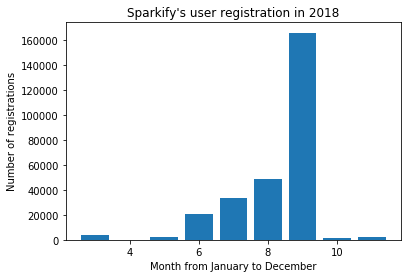

In [115]:
plt.figure();
plt.bar(pd_reg_date.month, pd_reg_date["count"]);
plt.xlabel("Month from January to December");
plt.ylabel("Number of registrations");
plt.title("Sparkify's user registration in 2018")

### Define Churn-Rate

In [ ]:
more friends = unlikely to quit

In [ ]:
#df_clean.groupby("level").count().describe().show()

### Data exploration

In [ ]:
# playtime over day

# number of next clicks and downgrade

# paid unpaid amount

# time between registration and unsubsricbe request

In [ ]:
df_valid.groupby("level").count().show()
# if artists na will be dropped only "nextSong" page remains
df_test = df.dropna(how = "any", subset = ["artist"])

In [ ]:
df_valid.groupby("level").count().show()

In [ ]:
# downgrade
df.filter("page = 'Submit Downgrade' and userID = '13'").show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.